In [5]:
!hdfs dfsadmin -fs hdfs://nn:9000/ -report

Configured Capacity: 25821052928 (24.05 GB)
Present Capacity: 13958586368 (13.00 GB)
DFS Remaining: 13958557696 (13.00 GB)
DFS Used: 28672 (28 KB)
DFS Used%: 0.00%
Replicated Blocks:
	Under replicated blocks: 0
	Blocks with corrupt replicas: 0
	Missing blocks: 0
	Missing blocks (with replication factor 1): 0
	Low redundancy blocks with highest priority to recover: 0
	Pending deletion blocks: 0
Erasure Coded Block Groups: 
	Low redundancy block groups: 0
	Block groups with corrupt internal blocks: 0
	Missing block groups: 0
	Low redundancy blocks with highest priority to recover: 0
	Pending deletion blocks: 0

-------------------------------------------------
Live datanodes (1):

Name: 192.168.160.6:9866 (project-5-p5-aschahal-dn-1.project-5-p5-aschahal_default)
Hostname: e69220ffb145
Decommission Status : Normal
Configured Capacity: 25821052928 (24.05 GB)
DFS Used: 28672 (28 KB)
Non DFS Used: 11845689344 (11.03 GB)
DFS Remaining: 13958557696 (13.00 GB)
DFS Used%: 0.00%
DFS Remaining%: 

In [6]:
!hdfs dfs -D dfs.replication=1 -cp -f data/*.csv hdfs://nn:9000/

In [8]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://boss:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

In [9]:
#q1
banks_df = spark.read.option("header", "true").option("inferSchema", "true").csv("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv")
count = banks_df.rdd.filter(lambda row: "The" in row['respondent_name'] and "National" in row['respondent_name']).count()
count

106

In [10]:
#q2
count = banks_df.filter(banks_df['respondent_name'].contains("The") & banks_df['respondent_name'].contains("National")).count()
count

106

In [11]:
banks_df.write.saveAsTable("banks", mode="overwrite")

24/04/05 23:12:38 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/04/05 23:12:38 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
24/04/05 23:12:43 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
24/04/05 23:12:43 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@192.168.160.3
24/04/05 23:12:45 WARN HadoopFSUtils: The directory hdfs://nn:9000/user/hive/warehouse/banks was not found. Was it deleted very recently?
24/04/05 23:12:45 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
24/04/05 23:12:46 WARN FileUtils: File does not exist: hdfs://nn:9000/user/hive/warehouse/banks; Force to delete it.
24/04/05 23:12:46 ERROR FileUtils: Failed to delete hdfs://nn:9000/user/hive/warehouse/banks
24/04/05 23:12:49 WARN SessionSt

In [13]:
#q3
result = spark.sql("SELECT COUNT(*) as count FROM banks WHERE respondent_name LIKE '%The%' AND respondent_name LIKE '%National%'")
count = result.collect()[0]['count']
count

106

In [14]:
loans_df = spark.read.option("header", "true").option("inferSchema", "true").csv("hdfs://nn:9000/hdma-wi-2021.csv")
loans_df.write.bucketBy(8, "county_code").saveAsTable("loans", format="parquet", mode="overwrite")
!hdfs dfs -ls hdfs://nn:9000/user/hive/warehouse/loans

24/04/06 00:10:23 WARN HadoopFSUtils: The directory hdfs://nn:9000/user/hive/warehouse/loans was not found. Was it deleted very recently?
24/04/06 00:10:24 WARN FileUtils: File does not exist: hdfs://nn:9000/user/hive/warehouse/loans; Force to delete it.
24/04/06 00:10:24 ERROR FileUtils: Failed to delete hdfs://nn:9000/user/hive/warehouse/loans
24/04/06 00:10:24 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Found 17 items
-rw-r--r--   3 root supergroup          0 2024-04-06 00:10 hdfs://nn:9000/user/hive/warehouse/loans/_SUCCESS
-rw-r--r--   3 root supergroup     601787 2024-04-06 00:10 hdfs://nn:9000/user/hive/warehouse/loans/part-00000-06af475e-df01-47c1-aa71-5e138080d835_00000.c000.snappy.parquet
-rw-r--r--   3 root supergroup     981619 2024-04-06 00:10 hdfs://nn:9000/user/hive/warehouse/loans/part-00000-06af475e-df01-47c1-aa71-5e138080d835_00001.c000.snappy.parquet
-rw-r--r--   3 root supergroup     844536 2024-04-06 00:10 hdfs://nn:9000/user/hive/warehouse/loans/part-00000-06af475e-df01-47c1-aa71-5e138080d835_00002.c000.snappy.parquet
-rw-r--r--   3 root supergroup     687680 2024-04-06 00:10 hdfs://nn:9000/user/hive/warehouse/loans/part-00000-06af475e-df01-47c1-aa71-5e138080d835_00003.c000.snappy.parquet
-rw-r--r--   3 root supergroup     894712 2024-04-06 00:10 hdfs://nn:9000/user/hive/warehouse/loans/part-00000-06af475e-df01-47c1-aa71-5e138080d835_00004.c000.snappy.parquet
-rw-r-

In [15]:
datasets = [
    "ethnicity", "race", "sex", "states", "counties", "tracts", "action_taken",
     "denial_reason", "loan_type", "loan_purpose", "preapproval", "property_type"
]

for dataset in datasets:
    df = spark.read.option("header", "true").option("inferSchema", "true").csv(f"hdfs://nn:9000/{dataset}.csv")
    df.createOrReplaceTempView(dataset)

In [16]:
#q4
tables_df = spark.sql("SHOW TABLES")
tables_list = tables_df.collect()
table_dict = {row.tableName: row.isTemporary for row in tables_list}
table_dict

{'banks': False,
 'loans': False,
 'action_taken': True,
 'counties': True,
 'denial_reason': True,
 'ethnicity': True,
 'loan_purpose': True,
 'loan_type': True,
 'preapproval': True,
 'property_type': True,
 'race': True,
 'sex': True,
 'states': True,
 'tracts': True}

In [17]:
#q5
query = """
SELECT COUNT(*) AS loan_applications_count
FROM loans
INNER JOIN banks ON loans.lei = banks.lei_2020
WHERE banks.respondent_name = 'First National Bank'
"""

result = spark.sql(query)
loan_applications_count = result.collect()[0]['loan_applications_count']
loan_applications_count

6

In [18]:
#q6
result.explain("formatted")
# 1.) Spark chose to broadcast the smaller table involved in the join.
# 2.) This operation is used to aggregate data based on hashing, whic is common for operations like COUNT, SUM, AVG, etc. 

== Physical Plan ==
AdaptiveSparkPlan (25)
+- == Final Plan ==
   * HashAggregate (15)
   +- ShuffleQueryStage (14), Statistics(sizeInBytes=32.0 B, rowCount=2)
      +- Exchange (13)
         +- * HashAggregate (12)
            +- * Project (11)
               +- * BroadcastHashJoin Inner BuildRight (10)
                  :- * Filter (3)
                  :  +- * ColumnarToRow (2)
                  :     +- Scan parquet spark_catalog.default.loans (1)
                  +- BroadcastQueryStage (9), Statistics(sizeInBytes=8.0 MiB, rowCount=8)
                     +- BroadcastExchange (8)
                        +- * Project (7)
                           +- * Filter (6)
                              +- * ColumnarToRow (5)
                                 +- Scan parquet spark_catalog.default.banks (4)
+- == Initial Plan ==
   HashAggregate (24)
   +- Exchange (23)
      +- HashAggregate (22)
         +- Project (21)
            +- BroadcastHashJoin Inner BuildRight (20)
               :- 

In [20]:
wells_fargo_loans = """
SELECT counties.NAME AS county_name, AVG(loans.loan_amount) AS avg_loan_amount
FROM loans
JOIN banks ON loans.lei = banks.lei_2020
JOIN counties ON loans.county_code = counties.STATE*1000 + counties.COUNTY
WHERE banks.respondent_name LIKE '%Wells Fargo%'
GROUP BY counties.NAME
ORDER BY avg_loan_amount DESC
LIMIT 10
"""

top_counties = spark.sql(wells_fargo_loans).collect()
top_county_names = [row['county_name'] for row in top_counties]

In [21]:
applications_count_query = f"""
SELECT counties.NAME AS county_name, COUNT(*) AS application_count
FROM loans
JOIN banks ON loans.lei = banks.lei_2020
JOIN counties ON loans.county_code = counties.STATE*1000 + counties.COUNTY
WHERE banks.respondent_name LIKE '%Wells Fargo%'
AND counties.NAME IN ({','.join(["'" + name + "'" for name in top_county_names])})
GROUP BY counties.NAME
"""

applications_count = spark.sql(applications_count_query).collect()

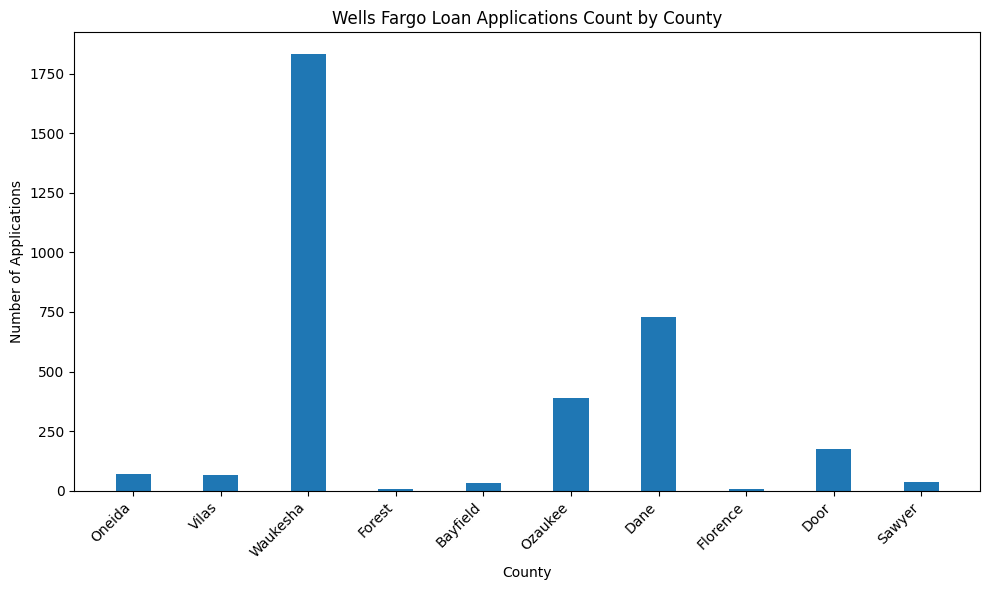

{'Oneida': 70,
 'Vilas': 68,
 'Waukesha': 1832,
 'Forest': 7,
 'Bayfield': 33,
 'Ozaukee': 389,
 'Dane': 729,
 'Florence': 8,
 'Door': 174,
 'Sawyer': 38}

In [23]:
#q7
result_dict = {}
for row in applications_count:
    result_dict[row['county_name']] = row['application_count']

import matplotlib.pyplot as plt

names = list(result_dict.keys())
values = list(result_dict.values())

plt.figure(figsize=(10, 6))
plt.bar(names, values, width=0.4)
plt.xticks(rotation=45, ha='right')
plt.xlabel('County')
plt.ylabel('Number of Applications')
plt.title('Wells Fargo Loan Applications Count by County')
plt.tight_layout()
plt.show()

result_dict

In [25]:
# Group by county_code
county = spark.table("loans").groupBy("county_code").mean("loan_amount")
county.explain()

# Group by lei
lei = spark.table("loans").groupBy("lei").mean("loan_amount")
lei.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[county_code#997], functions=[avg(loan_amount#1014)])
   +- HashAggregate(keys=[county_code#997], functions=[partial_avg(loan_amount#1014)])
      +- FileScan parquet spark_catalog.default.loans[county_code#997,loan_amount#1014] Batched: true, Bucketed: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[hdfs://nn:9000/user/hive/warehouse/loans], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<county_code:string,loan_amount:double>, SelectedBucketsCount: 8 out of 8


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[lei#994], functions=[avg(loan_amount#1014)])
   +- Exchange hashpartitioning(lei#994, 200), ENSURE_REQUIREMENTS, [plan_id=1191]
      +- HashAggregate(keys=[lei#994], functions=[partial_avg(loan_amount#1014)])
         +- FileScan parquet spark_catalog.default.loans[lei#994,loan_amount#1014] Batched: true, Bucketed: false (bucket co

In [17]:
#q8
# If the loans table was bucketed by county_code when saved to Hive, then grouping by county_code would not
# require a shuffle because the data is already partitioned by that key. However, grouping by lei would require
# shuffling because the data isn't partitioned by lei, and Spark needs to redistribute the data to calculate the mean.

In [28]:
#q9
from pyspark.sql.functions import col, when

df = spark.sql("SELECT loan_amount, income, interest_rate, action_taken as approval FROM loans")

df = df.na.fill(0.0, subset=["loan_amount", "income", "interest_rate", "approval"])
train, test = df.randomSplit([0.8, 0.2], seed=41)

train.cache()

approved_loans_count = train.where(col("approval") == 1).count()

approved_loans_count

24/04/06 00:43:28 WARN CacheManager: Asked to cache already cached data.


242713

In [30]:
#q10
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

df = spark.sql("""
    SELECT CAST(loan_amount AS DOUBLE),
           CAST(income AS DOUBLE),
           CAST(interest_rate AS DOUBLE),
           CASE WHEN action_taken = 'Loan originated' THEN 1.0 ELSE 0.0 END AS approval
    FROM loans
""")

df = df.na.fill(0.0, subset=["loan_amount", "income", "interest_rate", "approval"])
train, test = df.randomSplit([0.8, 0.2], seed=41)

train.cache()

features = ['loan_amount', 'income', 'interest_rate']
assembler = VectorAssembler(inputCols=features, outputCol="features")
train = assembler.transform(train).select("features", col("approval").alias("label"))
test = assembler.transform(test).select("features", col("approval").alias("label"))

rf = RandomForestClassifier(numTrees=10, labelCol="label", featuresCol="features")

rf_model = rf.fit(train)

predictions = rf_model.transform(test)

correct_predictions = predictions.where(predictions.label == predictions.prediction).count()
total_predictions = predictions.count()
accuracy = correct_predictions / total_predictions

accuracy

24/04/06 00:52:42 WARN CacheManager: Asked to cache already cached data.


1.0